In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
# Get co-occurences
import pandas as pd
import numpy as np
from collections import defaultdict

def co_occurrence(sentences, window_size, vocab):
    d = defaultdict(int)
    for text in sentences:
        # iterate over sentences
        for i in range(len(text)):
            token = text[i]
            if token in vocab:
                next_token = text[i+1 : i+1+window_size]
                for t in next_token:
                    if t in vocab:
                        key = tuple(sorted([t, token]))
                        d[key] += 1
    
    # formulate the dictionary into dataframe
    df = pd.DataFrame(data=np.zeros((len(vocab), len(vocab)), dtype=np.int16),
                      index=vocab,
                      columns=vocab)
    for key, value in d.items():
        df.at[key[0], key[1]] = value
        df.at[key[1], key[0]] = value
    return df

In [ ]:
# Get PMI
import numpy as np

def pmi(df, positive=True):
    col_totals = df.sum(axis=0)
    total = col_totals.sum()
    row_totals = df.sum(axis=1)
    expected = np.outer(row_totals, col_totals) / total
    df = df / expected
    # Silence distracting warnings about log(0):
    with np.errstate(divide='ignore'):
        df = np.log(df)
    df[np.isinf(df)] = 0.0  # log(0) = 0
    if positive:
        df[df < 0] = 0.0
    return df

In [ ]:
window_size = 5

In [ ]:
from gensim.models import Word2Vec
from tqdm import tqdm
from ast import literal_eval

# Collect all vocabulary
all_vocab = set()
years = [i for i in range(2007, 2020)]
for year in tqdm(years):
    model = Word2Vec.load(f'/content/gdrive/MyDrive/Colab Notebooks/Thesis/Models/Social media/Word2vec/word2vec_{year}.model')
    vocab = model.wv.index_to_key
    all_vocab.update(vocab)

100%|██████████| 13/13 [00:23<00:00,  1.78s/it]


In [ ]:
# The vocabulary is too large, let us take just the shared words we are mostly interested in
len(all_vocab)

63089

In [ ]:
import json

with open('/content/gdrive/MyDrive/Colab Notebooks/Thesis/Data/Social media/Common/shared_words_social_media.json', 'r') as f:
    words = json.load(f)
words = [w[0] for w in words.items()]

In [ ]:
len(words)

6453

In [ ]:
all_vocab = words

In [ ]:
import json

with open('/content/gdrive/MyDrive/Colab Notebooks/Thesis/Data/Social media/Dynamic/social_media_all_vocab.json', 'w', encoding='utf-8') as f:
    json.dump(json.dumps(list(all_vocab)), f)

In [ ]:
import json

with open('/content/gdrive/MyDrive/Colab Notebooks/Thesis/Data/Social media/Dynamic/social_media_all_vocab.json', 'r', encoding='utf-8') as f:
    all_vocab = json.loads(json.load(f))

In [ ]:
word_to_index = {w: i for i, w in enumerate(all_vocab)}

In [ ]:
import numpy as np
from gensim.models import Word2Vec
from tqdm import tqdm

# Initialize U matrix with static embeddings
years = [i for i in range(2007, 2020)]
U = [np.zeros((len(all_vocab), 300)) for t in years]

i = 0
for year in tqdm(years):
    model = Word2Vec.load(f'/content/gdrive/MyDrive/Colab Notebooks/Thesis/Models/Social media/Word2vec/word2vec_{year}.model')
    for word in model.wv.index_to_key:
        if word not in word_to_index:
            continue
        embed = model.wv[word]
        U[i][word_to_index[word]] = embed
    i += 1
U = np.asarray(U)

100%|██████████| 13/13 [00:11<00:00,  1.16it/s]


In [ ]:
from sklearn.decomposition import PCA
from tqdm import tqdm

# Reduce the dimensionality of word embeddings from 300 to 50
U_new = []
for i in tqdm(range(len(U))):
    pca = PCA(n_components=50)
    fitted = pca.fit_transform(U[i])
    U_new.append(fitted)

100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


In [ ]:
with open('/content/gdrive/MyDrive/Colab Notebooks/Thesis/Data/Social media/Dynamic/social_media_U_matrix.npy', 'wb') as f:
    np.save(f, U_new)

In [ ]:
with open('/content/gdrive/MyDrive/Colab Notebooks/Thesis/Data/Social media/Dynamic/social_media_U_matrix.npy', 'rb') as f:
    U = np.load(f)

In [ ]:
import pandas as pd
from gensim.models import Word2Vec
from tqdm import tqdm
from ast import literal_eval

# Compute PPMI
years = [i for i in range(2007, 2020)]
k = 0
for year in tqdm(years):
    df_temp = pd.read_csv(f'/content/gdrive/MyDrive/Colab Notebooks/Thesis/Data/Social media/Common/data_v1_{year}.csv', compression='zip',
                              converters={'tokenized_text': literal_eval, 'lemmas': literal_eval})
    
    model = Word2Vec.load(f'/content/gdrive/MyDrive/Colab Notebooks/Thesis/Models/Social media/Word2vec/word2vec_{year}.model')
    model_vocab = set(model.wv.index_to_key)
    vocab = list(model_vocab.intersection(set(all_vocab)))                
    ppmi_df = co_occurrence(df_temp.lemmas, window_size, vocab)

    column_words = ppmi_df.columns
    ppmi_df.index = column_words
    ppmi_df = pmi(ppmi_df)
    df_list = None

    for i in tqdm(range(len(ppmi_df.index))):
        word_1 = ppmi_df.index[i]
        for j in range(i, len(column_words)):
            word_2 = column_words[j]         
            if ppmi_df[word_1][word_2] > 0:
                if df_list is None:
                    df_list = [[word_to_index[word_1], word_to_index[word_2], ppmi_df[word_1][word_2]]]
                else:
                    df_list.append([word_to_index[word_1], word_to_index[word_2], ppmi_df[word_1][word_2]])

    df = pd.DataFrame(df_list)

    compression_opts = dict(method='zip', archive_name=f'list_ppmi_{k}.csv') 
    df.to_csv(f'/content/gdrive/MyDrive/Colab Notebooks/Thesis/Data/Social media/Dynamic/list_ppmi_{k}.csv', index=False, compression=compression_opts)
    k += 1

Streaming output truncated to the last 5000 lines.
100%|██████████| 3/3 [2:13:07<00:00, 2662.37s/it]


Train the model

In [ ]:
# Code is based on https://github.com/yifan0sun/DynamicWord2Vec/tree/master

#utility functions for running the CD method
#loss: min 1/2 \sum_t | Yt - UtVt' |^2 + lam/2 \sum_t(|Ut|^2 + |Vt|^2) + 
#                                        tau/2 \sum_t>1(|Vt - Vt-1|^2 + |Ut - Ut-1|^2)
#                                        gam/2 \sum_t (|Ut - Vt|^2)

import numpy as np
import scipy.io as sio
import copy
def update(U,Y,Vm1,Vp1,lam,tau,gam,ind,iflag):
    
    UtU = np.dot(U.T,U) # rxr
    r = UtU.shape[0]    
    if iflag:   M   = UtU + (lam + 2*tau + gam)*np.eye(r)
    else:       M   = UtU + (lam + tau + gam)*np.eye(r)
       
    Uty = np.dot(U.T,Y) # rxb
    Ub  = U[ind,:].T   # rxb
    A   = Uty + gam*Ub + tau*(Vm1.T+Vp1.T)  # rxb
    Vhat = np.linalg.lstsq(M,A) #rxb
    return Vhat[0].T #bxr


#for the above function, the equations are to update V. So:
#Y is n X b (b = batch size)
#r = rank
#U is n X r
#Vm1 and Vp1 are bXr. so they are b rows of V, transposed

def import_static_init(T):
    with open('/content/gdrive/MyDrive/Colab Notebooks/Thesis/Data/Social media/Dynamic/social_media_U_matrix.npy', 'rb') as f:
        emb = np.load(f)
    U = [copy.deepcopy(emb[t]) for t in T]
    V = [copy.deepcopy(emb[t]) for t in T]
    return U,V

def initvars(vocab_size,T,rank):
    # dictionary will store the variables U and V. tuple (t,i) indexes time t and word index i   
    U,V = [],[]
    U.append(np.random.randn(vocab_size,rank)/np.sqrt(rank))
    V.append(np.random.randn(vocab_size,rank)/np.sqrt(rank))
    for t in range(1,T):
        U.append(U[0].copy())
        V.append(V[0].copy())
        print(t)
    return U,V
    
import pandas as pd
import scipy.sparse as ss
def getmat(f,v,rowflag):
    data = pd.read_csv(f, compression='zip')
    data = data.values
    
    X = ss.coo_matrix((data[:,2],(data[:,0],data[:,1])),shape=(v,v))
   
   
    if rowflag: 
        X = ss.csr_matrix(X)
        # X = X[inds,:]
    else:
        X = ss.csc_matrix(X)
        # X = X[:,inds]
    
    return X#.todense()

def getbatches(vocab,b):
    batchinds = []
    current = 0
    while current<vocab:
        inds = range(current,min(current+b,vocab))
        current = min(current+b,vocab)
        batchinds.append(inds)
    return batchinds

#   THE FOLLOWING FUNCTION TAKES A WORD ID AND RETURNS CLOSEST WORDS BY COSINE DISTANCE
from sklearn.metrics.pairwise import cosine_similarity
def getclosest(wid,U):
    C = []
    for t in range(len(U)):
        temp = U[t]
        K = cosine_similarity([temp[wid,:]],temp)
        mxinds = np.argsort(-K)
        mxinds = mxinds[0:10]
        C.append(mxinds)
    return C
        
# THE FOLLOWING FUNCTIONS COMPUTES THE REGULARIZER SCORES GIVEN U AND V ENTRIES
def compute_symscore(U,V):
    return np.linalg.norm(U-V)**2

def compute_smoothscore(U,Um1,Up1):
    X = np.linalg.norm(U-Up1)**2 + np.linalg.norm(U-Um1)**2
    return X

In [ ]:
# Code is based on https://github.com/yifan0sun/DynamicWord2Vec/tree/master

# main script for time CD 
# trainfile has lines of the form
# tok1,tok2,pmi

import numpy as np
import pickle as pickle

# PARAMETERS

nw = 6453 # number of words in vocab
T = range(13) # total number of time points
cuda = False

trainhead = '/content/gdrive/MyDrive/Colab Notebooks/Thesis/Data/Social media/Dynamic/list_ppmi_' # location of training data
savehead = '/content/gdrive/MyDrive/Colab Notebooks/Thesis/Models/Social media/Dynamic/Results/'
    
def print_params(r,lam,tau,gam,emph,ITERS):
    
    print('rank = {}'.format(r))
    print('frob  regularizer = {}'.format(lam))
    print('time  regularizer = {}'.format(tau))
    print('symmetry regularizer = {}'.format(gam))
    print('emphasize param   = {}'.format(emph))
    print('total iterations = {}'.format(ITERS))
    
if __name__=='__main__':
    import sys
    ITERS = 53 # total passes over the data
    lam = 10 #frob regularizer
    gam = 50 # forcing regularizer
    tau = 50  # smoothing regularizer
    r   = 50  # rank
    b = nw # batch size
    emph = 1 # emphasize the nonzero

    foo = sys.argv
    for i in range(1,len(foo)):
        if foo[i]=='-r':    r = int(float(foo[i+1]))        
        if foo[i]=='-iters': ITERS = int(float(foo[i+1]))            
        if foo[i]=='-lam':    lam = float(foo[i+1])
        if foo[i]=='-tau':    tau = float(foo[i+1])
        if foo[i]=='-gam':    gam = float(foo[i+1])
        if foo[i]=='-b':    b = int(float(foo[i+1]))
        if foo[i]=='-emph': emph = float(foo[i+1])
        if foo[i]=='-check': erchk=foo[i+1]
    
        
    savefile = savehead+'L'+str(lam)+'T'+str(tau)+'G'+str(gam)+'A'+str(emph)
    
    print('starting training with following parameters')
    print_params(r,lam,tau,gam,emph,ITERS)
    print('there are a total of {} words, and {} time points'.format(nw,T))
    
    print('X*X*X*X*X*X*X*X*X')
    print('initializing')
    
    Ulist,Vlist = import_static_init(T)

    print('getting batch indices')
    if b < nw:
        b_ind = getbatches(nw,b)
    else:
        b_ind = [range(nw)]
    
    import time
    start_time = time.time()
    # sequential updates
    for iteration in range(29, ITERS):  
        print_params(r,lam,tau,gam,emph,ITERS)
        try:
            Ulist = pickle.load(open( "%sngU_iter%d.p" % (savefile,iteration), "rb" ) )
            Vlist = pickle.load(open( "%sngV_iter%d.p" % (savefile, iteration), "rb" ) )
            print(f'iteration {iteration} loaded succesfully')
            continue
        except(IOError):
            pass
        loss = 0
        # shuffle times
        if iteration == 0: times = T
        else: times = np.random.permutation(T)
        
        for t in range(len(times)):   # select a time
            print(f'iteration {iteration}, time {t}')
            f = trainhead + str(t) + '.csv'
            print(f)
            
            pmi = getmat(f,nw,False)
            for j in range(len(b_ind)): # select a mini batch
                print(f'{j} out of {len(b_ind)}')
                ind = b_ind[j]
                ## UPDATE V
                # get data
                pmi_seg = pmi[:,ind].todense()
                
                if t==0:
                    vp = np.zeros((len(ind),r))
                    up = np.zeros((len(ind),r))
                    iflag = True
                else:
                    vp = Vlist[t-1][ind,:]
                    up = Ulist[t-1][ind,:]
                    iflag = False

                if t==len(T)-1:
                    vn = np.zeros((len(ind),r))
                    un = np.zeros((len(ind),r))
                    iflag = True
                else:
                    vn = Vlist[t+1][ind,:]
                    un = Ulist[t+1][ind,:]
                    iflag = False
                Vlist[t][ind,:] = update(Ulist[t],emph*pmi_seg,vp,vn,lam,tau,gam,ind,iflag)
                Ulist[t][ind,:] = update(Vlist[t],emph*pmi_seg,up,un,lam,tau,gam,ind,iflag)
                
            ####  INNER BATCH LOOP END
                
        # save
        print('time elapsed = ', time.time()-start_time)
       
        pickle.dump(Ulist, open( "%sngU_iter%d.p" % (savefile,iteration), "wb" ) , pickle.HIGHEST_PROTOCOL)
        pickle.dump(Vlist, open( "%sngV_iter%d.p" % (savefile, iteration), "wb" ) , pickle.HIGHEST_PROTOCOL)

starting training with following parameters
rank = 50
frob  regularizer = 10
time  regularizer = 50
symmetry regularizer = 50
emphasize param   = 1
total iterations = 60
there are a total of 6453 words, and range(0, 13) time points
X*X*X*X*X*X*X*X*X
initializing
getting batch indices
rank = 50
frob  regularizer = 10
time  regularizer = 50
symmetry regularizer = 50
emphasize param   = 1
total iterations = 60
iteration 29 loaded succesfully
rank = 50
frob  regularizer = 10
time  regularizer = 50
symmetry regularizer = 50
emphasize param   = 1
total iterations = 60
iteration 30, time 0
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_0.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 30, time 1
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_1.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 30, time 2
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_2.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 30, time 3
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_3.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 30, time 4
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_4.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 30, time 5
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_5.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 30, time 6
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_6.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 30, time 7
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_7.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 30, time 8
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_8.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 30, time 9
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_9.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 30, time 10
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_10.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 30, time 11
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_11.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 30, time 12
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_12.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


time elapsed =  49.11949968338013
rank = 50
frob  regularizer = 10
time  regularizer = 50
symmetry regularizer = 50
emphasize param   = 1
total iterations = 60
iteration 31, time 0
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_0.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 31, time 1
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_1.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 31, time 2
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_2.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 31, time 3
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_3.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 31, time 4
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_4.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 31, time 5
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_5.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 31, time 6
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_6.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 31, time 7
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_7.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 31, time 8
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_8.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 31, time 9
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_9.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 31, time 10
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_10.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 31, time 11
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_11.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 31, time 12
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_12.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


time elapsed =  99.8648419380188
rank = 50
frob  regularizer = 10
time  regularizer = 50
symmetry regularizer = 50
emphasize param   = 1
total iterations = 60
iteration 32, time 0
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_0.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 32, time 1
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_1.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 32, time 2
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_2.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 32, time 3
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_3.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 32, time 4
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_4.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 32, time 5
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_5.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 32, time 6
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_6.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 32, time 7
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_7.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 32, time 8
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_8.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 32, time 9
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_9.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 32, time 10
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_10.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 32, time 11
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_11.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 32, time 12
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_12.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


time elapsed =  149.36650609970093
rank = 50
frob  regularizer = 10
time  regularizer = 50
symmetry regularizer = 50
emphasize param   = 1
total iterations = 60
iteration 33, time 0
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_0.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 33, time 1
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_1.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 33, time 2
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_2.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 33, time 3
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_3.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 33, time 4
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_4.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 33, time 5
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_5.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 33, time 6
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_6.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 33, time 7
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_7.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 33, time 8
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_8.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 33, time 9
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_9.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 33, time 10
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_10.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 33, time 11
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_11.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 33, time 12
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_12.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


time elapsed =  198.28780817985535
rank = 50
frob  regularizer = 10
time  regularizer = 50
symmetry regularizer = 50
emphasize param   = 1
total iterations = 60
iteration 34, time 0
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_0.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 34, time 1
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_1.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 34, time 2
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_2.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 34, time 3
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_3.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 34, time 4
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_4.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 34, time 5
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_5.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 34, time 6
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_6.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 34, time 7
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_7.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 34, time 8
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_8.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 34, time 9
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_9.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 34, time 10
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_10.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 34, time 11
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_11.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 34, time 12
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_12.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


time elapsed =  245.85448932647705
rank = 50
frob  regularizer = 10
time  regularizer = 50
symmetry regularizer = 50
emphasize param   = 1
total iterations = 60
iteration 35, time 0
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_0.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 35, time 1
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_1.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 35, time 2
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_2.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 35, time 3
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_3.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 35, time 4
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_4.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 35, time 5
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_5.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 35, time 6
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_6.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 35, time 7
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_7.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 35, time 8
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_8.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 35, time 9
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_9.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 35, time 10
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_10.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 35, time 11
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_11.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 35, time 12
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_12.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


time elapsed =  295.3291983604431
rank = 50
frob  regularizer = 10
time  regularizer = 50
symmetry regularizer = 50
emphasize param   = 1
total iterations = 60
iteration 36, time 0
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_0.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 36, time 1
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_1.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 36, time 2
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_2.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 36, time 3
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_3.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 36, time 4
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_4.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 36, time 5
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_5.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 36, time 6
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_6.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 36, time 7
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_7.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 36, time 8
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_8.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 36, time 9
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_9.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 36, time 10
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_10.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 36, time 11
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_11.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 36, time 12
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_12.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


time elapsed =  344.13642168045044
rank = 50
frob  regularizer = 10
time  regularizer = 50
symmetry regularizer = 50
emphasize param   = 1
total iterations = 60
iteration 37, time 0
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_0.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 37, time 1
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_1.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 37, time 2
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_2.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 37, time 3
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_3.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 37, time 4
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_4.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 37, time 5
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_5.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 37, time 6
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_6.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 37, time 7
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_7.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 37, time 8
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_8.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 37, time 9
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_9.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 37, time 10
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_10.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 37, time 11
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_11.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 37, time 12
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_12.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


time elapsed =  392.9132556915283
rank = 50
frob  regularizer = 10
time  regularizer = 50
symmetry regularizer = 50
emphasize param   = 1
total iterations = 60
iteration 38, time 0
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_0.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 38, time 1
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_1.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 38, time 2
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_2.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 38, time 3
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_3.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 38, time 4
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_4.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 38, time 5
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_5.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 38, time 6
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_6.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 38, time 7
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_7.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 38, time 8
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_8.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 38, time 9
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_9.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 38, time 10
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_10.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 38, time 11
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_11.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 38, time 12
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_12.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


time elapsed =  445.8007848262787
rank = 50
frob  regularizer = 10
time  regularizer = 50
symmetry regularizer = 50
emphasize param   = 1
total iterations = 60
iteration 39, time 0
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_0.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 39, time 1
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_1.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 39, time 2
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_2.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 39, time 3
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_3.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 39, time 4
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_4.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 39, time 5
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_5.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 39, time 6
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_6.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 39, time 7
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_7.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 39, time 8
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_8.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 39, time 9
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_9.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 39, time 10
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_10.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 39, time 11
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_11.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 39, time 12
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_12.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


time elapsed =  494.1846947669983
rank = 50
frob  regularizer = 10
time  regularizer = 50
symmetry regularizer = 50
emphasize param   = 1
total iterations = 60
iteration 40, time 0
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_0.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 40, time 1
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_1.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 40, time 2
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_2.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 40, time 3
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_3.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 40, time 4
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_4.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 40, time 5
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_5.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 40, time 6
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_6.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 40, time 7
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_7.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 40, time 8
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_8.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 40, time 9
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_9.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 40, time 10
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_10.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 40, time 11
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_11.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 40, time 12
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_12.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


time elapsed =  542.3443207740784
rank = 50
frob  regularizer = 10
time  regularizer = 50
symmetry regularizer = 50
emphasize param   = 1
total iterations = 60
iteration 41, time 0
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_0.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 41, time 1
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_1.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 41, time 2
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_2.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 41, time 3
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_3.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 41, time 4
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_4.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 41, time 5
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_5.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 41, time 6
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_6.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 41, time 7
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_7.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 41, time 8
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_8.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 41, time 9
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_9.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 41, time 10
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_10.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 41, time 11
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_11.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 41, time 12
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_12.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


time elapsed =  589.8560531139374
rank = 50
frob  regularizer = 10
time  regularizer = 50
symmetry regularizer = 50
emphasize param   = 1
total iterations = 60
iteration 42, time 0
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_0.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 42, time 1
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_1.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 42, time 2
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_2.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 42, time 3
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_3.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 42, time 4
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_4.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 42, time 5
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_5.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 42, time 6
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_6.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 42, time 7
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_7.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 42, time 8
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_8.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 42, time 9
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_9.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 42, time 10
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_10.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 42, time 11
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_11.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 42, time 12
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_12.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


time elapsed =  639.019012928009
rank = 50
frob  regularizer = 10
time  regularizer = 50
symmetry regularizer = 50
emphasize param   = 1
total iterations = 60
iteration 43, time 0
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_0.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 43, time 1
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_1.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 43, time 2
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_2.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 43, time 3
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_3.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 43, time 4
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_4.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 43, time 5
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_5.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 43, time 6
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_6.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 43, time 7
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_7.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 43, time 8
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_8.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 43, time 9
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_9.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 43, time 10
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_10.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 43, time 11
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_11.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 43, time 12
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_12.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


time elapsed =  688.1953120231628
rank = 50
frob  regularizer = 10
time  regularizer = 50
symmetry regularizer = 50
emphasize param   = 1
total iterations = 60
iteration 44, time 0
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_0.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 44, time 1
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_1.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 44, time 2
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_2.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 44, time 3
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_3.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 44, time 4
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_4.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 44, time 5
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_5.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 44, time 6
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_6.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 44, time 7
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_7.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 44, time 8
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_8.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 44, time 9
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_9.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 44, time 10
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_10.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 44, time 11
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_11.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 44, time 12
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_12.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


time elapsed =  735.7173881530762
rank = 50
frob  regularizer = 10
time  regularizer = 50
symmetry regularizer = 50
emphasize param   = 1
total iterations = 60
iteration 45, time 0
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_0.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 45, time 1
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_1.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 45, time 2
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_2.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 45, time 3
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_3.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 45, time 4
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_4.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 45, time 5
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_5.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 45, time 6
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_6.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 45, time 7
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_7.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 45, time 8
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_8.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 45, time 9
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_9.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 45, time 10
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_10.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 45, time 11
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_11.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 45, time 12
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_12.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


time elapsed =  784.2649981975555
rank = 50
frob  regularizer = 10
time  regularizer = 50
symmetry regularizer = 50
emphasize param   = 1
total iterations = 60
iteration 46, time 0
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_0.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 46, time 1
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_1.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 46, time 2
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_2.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 46, time 3
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_3.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 46, time 4
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_4.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 46, time 5
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_5.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 46, time 6
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_6.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 46, time 7
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_7.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 46, time 8
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_8.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 46, time 9
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_9.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 46, time 10
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_10.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 46, time 11
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_11.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 46, time 12
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_12.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


time elapsed =  831.953882932663
rank = 50
frob  regularizer = 10
time  regularizer = 50
symmetry regularizer = 50
emphasize param   = 1
total iterations = 60
iteration 47, time 0
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_0.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 47, time 1
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_1.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 47, time 2
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_2.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 47, time 3
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_3.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 47, time 4
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_4.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 47, time 5
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_5.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 47, time 6
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_6.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 47, time 7
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_7.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 47, time 8
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_8.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 47, time 9
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_9.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 47, time 10
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_10.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 47, time 11
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_11.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 47, time 12
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_12.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


time elapsed =  877.651878118515
rank = 50
frob  regularizer = 10
time  regularizer = 50
symmetry regularizer = 50
emphasize param   = 1
total iterations = 60
iteration 48, time 0
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_0.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 48, time 1
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_1.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 48, time 2
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_2.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 48, time 3
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_3.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 48, time 4
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_4.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 48, time 5
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_5.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 48, time 6
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_6.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 48, time 7
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_7.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 48, time 8
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_8.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 48, time 9
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_9.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 48, time 10
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_10.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 48, time 11
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_11.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 48, time 12
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_12.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


time elapsed =  924.3544478416443
rank = 50
frob  regularizer = 10
time  regularizer = 50
symmetry regularizer = 50
emphasize param   = 1
total iterations = 60
iteration 49, time 0
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_0.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 49, time 1
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_1.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 49, time 2
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_2.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 49, time 3
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_3.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 49, time 4
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_4.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 49, time 5
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_5.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 49, time 6
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_6.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 49, time 7
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_7.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 49, time 8
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_8.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 49, time 9
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_9.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 49, time 10
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_10.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 49, time 11
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_11.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 49, time 12
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_12.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


time elapsed =  970.9564399719238
rank = 50
frob  regularizer = 10
time  regularizer = 50
symmetry regularizer = 50
emphasize param   = 1
total iterations = 60
iteration 50, time 0
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_0.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 50, time 1
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_1.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 50, time 2
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_2.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 50, time 3
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_3.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 50, time 4
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_4.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 50, time 5
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_5.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 50, time 6
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_6.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 50, time 7
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_7.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 50, time 8
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_8.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 50, time 9
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_9.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 50, time 10
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_10.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 50, time 11
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_11.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 50, time 12
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_12.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


time elapsed =  1015.6242895126343
rank = 50
frob  regularizer = 10
time  regularizer = 50
symmetry regularizer = 50
emphasize param   = 1
total iterations = 60
iteration 51, time 0
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_0.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 51, time 1
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_1.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 51, time 2
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_2.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 51, time 3
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_3.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 51, time 4
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_4.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 51, time 5
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_5.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 51, time 6
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_6.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 51, time 7
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_7.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 51, time 8
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_8.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 51, time 9
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_9.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 51, time 10
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_10.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 51, time 11
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_11.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 51, time 12
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_12.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


time elapsed =  1069.95383477211
rank = 50
frob  regularizer = 10
time  regularizer = 50
symmetry regularizer = 50
emphasize param   = 1
total iterations = 60
iteration 52, time 0
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_0.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 52, time 1
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_1.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 52, time 2
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_2.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 52, time 3
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_3.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 52, time 4
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_4.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 52, time 5
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_5.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 52, time 6
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_6.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 52, time 7
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_7.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 52, time 8
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_8.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 52, time 9
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_9.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 52, time 10
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_10.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 52, time 11
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_11.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 52, time 12
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_12.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


time elapsed =  1117.7581994533539
rank = 50
frob  regularizer = 10
time  regularizer = 50
symmetry regularizer = 50
emphasize param   = 1
total iterations = 60
iteration 53, time 0
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_0.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 53, time 1
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_1.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 53, time 2
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_2.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 53, time 3
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_3.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 53, time 4
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_4.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 53, time 5
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_5.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 53, time 6
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_6.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 53, time 7
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_7.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 53, time 8
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_8.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 53, time 9
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_9.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 53, time 10
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_10.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 53, time 11
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_11.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 53, time 12
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_12.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


time elapsed =  1166.6868102550507
rank = 50
frob  regularizer = 10
time  regularizer = 50
symmetry regularizer = 50
emphasize param   = 1
total iterations = 60
iteration 54, time 0
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_0.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 54, time 1
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_1.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 54, time 2
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_2.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 54, time 3
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_3.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 54, time 4
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_4.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 54, time 5
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_5.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 54, time 6
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_6.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 54, time 7
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_7.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 54, time 8
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_8.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 54, time 9
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_9.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 54, time 10
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_10.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 54, time 11
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_11.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 54, time 12
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_12.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


time elapsed =  1215.486155986786
rank = 50
frob  regularizer = 10
time  regularizer = 50
symmetry regularizer = 50
emphasize param   = 1
total iterations = 60
iteration 55, time 0
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_0.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 55, time 1
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_1.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 55, time 2
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_2.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 55, time 3
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_3.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 55, time 4
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_4.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 55, time 5
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_5.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 55, time 6
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_6.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 55, time 7
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_7.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 55, time 8
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_8.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 55, time 9
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_9.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 55, time 10
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_10.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 55, time 11
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_11.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 55, time 12
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_12.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


time elapsed =  1263.1980555057526
rank = 50
frob  regularizer = 10
time  regularizer = 50
symmetry regularizer = 50
emphasize param   = 1
total iterations = 60
iteration 56, time 0
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_0.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 56, time 1
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_1.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 56, time 2
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_2.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 56, time 3
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_3.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 56, time 4
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_4.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 56, time 5
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_5.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 56, time 6
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_6.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 56, time 7
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_7.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 56, time 8
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_8.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 56, time 9
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_9.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 56, time 10
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_10.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 56, time 11
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_11.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 56, time 12
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_12.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


time elapsed =  1311.3366434574127
rank = 50
frob  regularizer = 10
time  regularizer = 50
symmetry regularizer = 50
emphasize param   = 1
total iterations = 60
iteration 57, time 0
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_0.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 57, time 1
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_1.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 57, time 2
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_2.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 57, time 3
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_3.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 57, time 4
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_4.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 57, time 5
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_5.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 57, time 6
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_6.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 57, time 7
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_7.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 57, time 8
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_8.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 57, time 9
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_9.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 57, time 10
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_10.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 57, time 11
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_11.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 57, time 12
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_12.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


time elapsed =  1358.8357303142548
rank = 50
frob  regularizer = 10
time  regularizer = 50
symmetry regularizer = 50
emphasize param   = 1
total iterations = 60
iteration 58, time 0
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_0.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 58, time 1
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_1.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 58, time 2
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_2.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 58, time 3
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_3.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 58, time 4
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_4.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 58, time 5
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_5.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 58, time 6
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_6.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 58, time 7
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_7.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 58, time 8
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_8.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 58, time 9
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_9.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 58, time 10
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_10.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 58, time 11
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_11.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 58, time 12
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_12.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


time elapsed =  1406.2804231643677
rank = 50
frob  regularizer = 10
time  regularizer = 50
symmetry regularizer = 50
emphasize param   = 1
total iterations = 60
iteration 59, time 0
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_0.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 59, time 1
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_1.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 59, time 2
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_2.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 59, time 3
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_3.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 59, time 4
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_4.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 59, time 5
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_5.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 59, time 6
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_6.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 59, time 7
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_7.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 59, time 8
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_8.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 59, time 9
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_9.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 59, time 10
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_10.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 59, time 11
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_11.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 59, time 12
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/Social media/list_ppmi_12.csv
0 out of 1


<ipython-input-11-687ce13563f1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


time elapsed =  1456.4345428943634


Find the words that experienced the most significant semantic shift

In [ ]:
import json

with open('/content/gdrive/MyDrive/Colab Notebooks/Thesis/Data/Social media/Dynamic/social_media_all_vocab.json', 'r', encoding='utf-8') as f:
    all_vocab = json.loads(json.load(f))

In [ ]:
word_to_index = {w: i for i, w in enumerate(all_vocab)}

In [ ]:
import json

with open('/content/gdrive/MyDrive/Colab Notebooks/thesis/Data/Social media/Common/shared_words_social_media.json', 'r') as f:
    words = json.load(f)
words = [w[0] for w in words.items()]
words_ids = [word_to_index[w] for w in words if w in word_to_index]

In [ ]:
import pandas as pd
import numpy as np
import scipy.sparse as ss
import pickle as pickle

savehead = '/content/gdrive/MyDrive/Colab Notebooks/Final/Models/Results/'
lam = 10 #frob regularizer
gam = 50 # forcing regularizer
tau = 50  # smoothing regularizer
emph = 1 # emphasize the nonzero
savefile = savehead+'L'+str(lam)+'T'+str(tau)+'G'+str(gam)+'A'+str(emph)
iteration = 52
Ulist = pickle.load(open( "%sngU_iter%d.p" % (savefile,iteration), "rb" ) )

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

cosine_similarities ={}

for w_id in tqdm(words_ids):
    embed_1 = Ulist[0][w_id]
    embed_2 = Ulist[12][w_id]
    cosine_similarities[(all_vocab[w_id], w_id)] = cosine_similarity([embed_1], 
                                                  [embed_2])[0][0]

100%|██████████| 6453/6453 [00:02<00:00, 2316.37it/s]


In [ ]:
top_20 = sorted(cosine_similarities.items(), key=lambda item: abs(item[1]))[:20]
top_20

[(('положение', 1362), 7.846428216664626e-05),
 (('игорь', 198), 0.0001467766712353307),
 (('научный', 1227), 0.00034610851477830454),
 (('французский', 2170), 0.0003797801677315159),
 (('голод', 2523), 0.0004667214781208188),
 (('думать', 68), -0.0006304911664730996),
 (('путы', 3958), -0.0008374055741157752),
 (('делить', 3909), 0.000875613298663141),
 (('таракан', 4723), -0.0008820017790125527),
 (('старенький', 4885), -0.0010739233843599545),
 (('гордо', 4663), -0.0010742612445927193),
 (('дак', 5767), -0.0011145095958128553),
 (('поверить', 1366), 0.0011576175205848973),
 (('увы', 2062), 0.0012494681768300089),
 (('дрянь', 5426), -0.0012718858733053728),
 (('править', 3470), -0.001468819820040622),
 (('раздел', 3169), 0.001503275441438255),
 (('огород', 4395), -0.001755074333212982),
 (('целое', 862), 0.0018158620106136078),
 (('аудио', 4209), 0.002012319162190447)]

In [ ]:
def getclosest(wid, U, y1, y2):
    C = []
    # for t in range(len(U)):
    temp_1 = U[y1]
    temp_2 = U[y2]
    K = cosine_similarity([temp_1[wid,:]],temp_2)
    mxinds = np.argsort(-abs(K[0]))
    mxinds = mxinds[0:10]
    # C.append(mxinds)
    return mxinds

In [ ]:
for word in top_20:
    print(word[0][0])
    closest_2007 = getclosest(word[0][1],Ulist, 0, 0)
    w_closest_2007  = [all_vocab[i] for i in closest_2007]
    print(w_closest_2007)
    closest_2019 = getclosest(word[0][1],Ulist, 12, 12)
    w_closest_2019  = [all_vocab[i] for i in closest_2019]
    print(w_closest_2019)

положение
['положение', 'граф', 'зависимость', 'разный', 'каков', 'собственно', 'однако', 'вполне', 'определ', 'влияние']
['положение', 'ориентация', 'внешний', 'интерес', 'однако', 'иметь', 'насколько', 'прогресс', 'соответственно', 'основный']
игорь
['игорь', 'андрей', 'олег', 'иван', 'макс', 'ф', 'запись', 'васильев', 'рома', 'зайти']
['игорь', 'андрей', 'сергей', 'денис', 'петров', 'артём', 'максим', 'константин', 'игоревич', 'валентин']
научный
['научный', 'социальный', 'технология', 'метод', 'учёный', 'анализ', 'данный', 'необходимость', 'управление', 'проверка']
['научный', 'учёный', 'исследование', 'психология', 'специалист', 'интеллектуальный', 'наиболее', 'программирование', 'конференция', 'практический']
французский
['французский', 'контрольный', 'исключительно', 'какой', 'начать', 'шведский', 'желательно', 'кошмар', 'смска', 'подряд']
['французский', 'русский', 'итальянский', 'английский', 'джон', 'оригинал', 'английски', 'назвать', 'америка', 'франция']
голод
['голод', 'ум

100%|██████████| 3/3 [00:01<00:00,  2.11it/s]


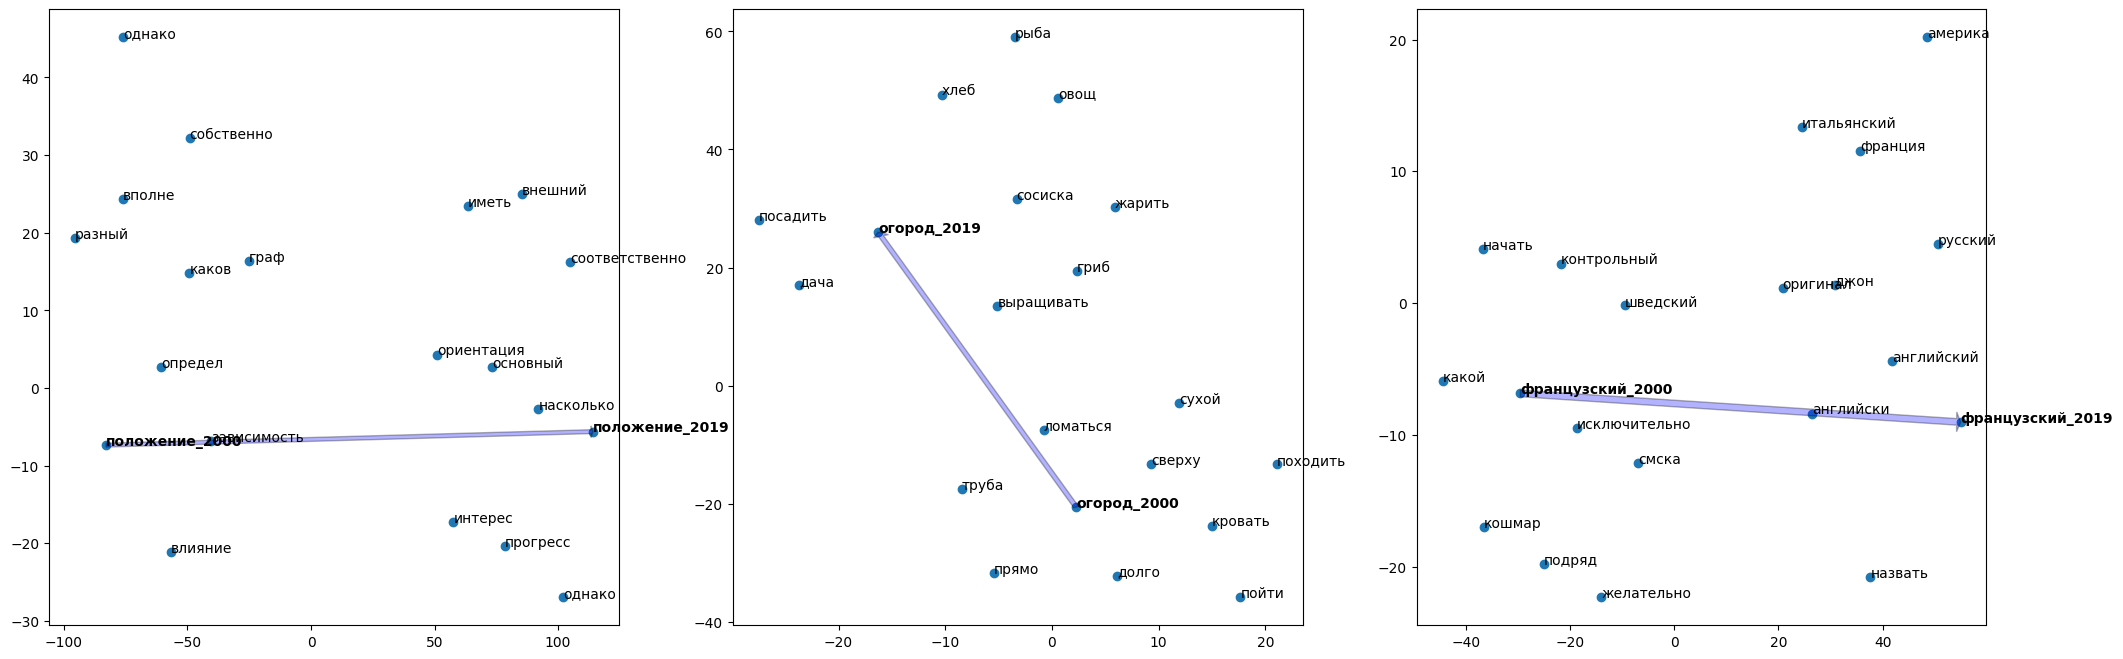

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm

words = ['положение', 'огород', 'французский']
years = [2007, 2019]

vectors_2007 = Ulist[0]
vectors_2019 = Ulist[12]

points = []
all_keys = []

for word in tqdm(words):
    wid = word_to_index[word]
    K_2007 = cosine_similarity([vectors_2007[wid,:]],vectors_2007)
    K_2019 = cosine_similarity([vectors_2019[wid,:]],vectors_2019)

    mxinds_2007 = np.argsort(-abs(K_2007[0]))
    mxinds_2007 = mxinds_2007[0:10]

    mxinds_2019 = np.argsort(-abs(K_2019[0]))
    mxinds_2019 = mxinds_2019[0:10]

    w_closest_2007  = [all_vocab[i] for i in mxinds_2007[1:]]
    w_closest_2019  = [all_vocab[i] for i in mxinds_2019[1:]]

    all_words = w_closest_2007
    all_words.extend(w_closest_2019)
    all_words.extend([f'{word}_2000', f'{word}_2019'])

    embeds_2007 = [vectors_2007[i] for i in mxinds_2007[1:]]
    embeds_2019 = [vectors_2019[i] for i in mxinds_2019[1:]]

    all_embeds = embeds_2007
    all_embeds.extend(embeds_2019)
    all_embeds.extend([vectors_2007[wid], vectors_2019[wid]])

    # Fit t-SNE
    mat = np.array(all_embeds)
    model = TSNE(n_components=2, random_state=0, init='pca', perplexity=10)
    fitted = model.fit_transform(mat)
    points.append(fitted)
    all_keys.append(all_words)

fig, ax = plt.subplots(1, 3)

fig.set_figheight(8)
fig.set_figwidth(25)

for j in range(3):
    fitted = points[j]
    x = fitted[:, 0]
    y = fitted[:, 1]
    keys = all_keys[j]

    ax[j].scatter(x, y)

    for i, txt in enumerate(keys):
        if len(keys) - i <= 2:
            ax[j].annotate(txt, (x[i], y[i]), weight='bold')
        else:
            ax[j].annotate(txt, (x[i], y[i]))
    
    ax[j].arrow(fitted[-2, 0], fitted[-2, 1], (fitted[-1, 0] - fitted[-2, 0]), 
              (fitted[-1, 1] - fitted[-2, 1]), facecolor='blue', alpha=0.3, width=0.5,
              head_length=0.75, length_includes_head=True)
fig.savefig(f'/content/gdrive/MyDrive/Colab Notebooks/Thesis/Vectors/sm_dyn.png')